In [1]:
import numpy as np
import core.vem as vem

# geometry data
L = 2.0
nodes = np.array([[0,0],[0,L],[L,L],[L,0]])
elements = np.array([[0,1],[1,2],[2,3]])
supp = np.array([[0,1,1,1], [3,1,1,1]])
I = 36e-4
A = 0.12

# material data
E = 20e6

# loads
load = np.array([[1,2]])
q = -400
t = 0
f_dist = vem.buildBeamDistributedLoad(load,t,q,nodes)

# stiffness matrix
K = vem.buildGlobaBeamK(nodes, elements, E, A, I, 1)

# apply DBC
K, f = vem.applyDBCBeam(K, f_dist, supp)

# solve
print()
print("######################### Beam ##########################")
uh_vem = np.linalg.solve(K,f)
print(uh_vem)
print("#########################################################")

Coords: [[0. 0.]
 [0. 2.]] - Length: 2.0
Coords: [[0. 2.]
 [2. 2.]] - Length: 2.0
Coords: [[2. 2.]
 [2. 0.]] - Length: 2.0

######################### Beam ##########################
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.16360817e-04
 -3.20308731e-04 -8.04745594e-04  5.44061872e-05 -3.46357935e-04
  6.33978590e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00]
#########################################################


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

def compute_loss(K, uh, F):
    """
    Compute the loss function as (K * uh - F)^2 using PyTorch

    Parameters:
    K (torch.Tensor): Stiffness matrix (ndof x ndof)
    uh (torch.Tensor): Solution vector (ndof x 1)
    F (torch.Tensor): Load vector (ndof x 1)

    Returns:
    torch.Tensor: The loss value
    """
    # Compute the residual
    R = torch.matmul(K, uh) - F
    
    # Compute the loss (squared residual)
    loss = torch.sum(R**2)
    
    return loss

def compute_boundary_loss(uh, supp):
    """
    Compute the loss function for enforcing the Dirichlet boundary conditions.

    Parameters:
    uh (torch.Tensor): Solution vector (ndof x 1)
    supp (torch.Tensor): Support vector (ndof x N, where N is the number of nodes with boundary conditions)

    Returns:
    torch.Tensor: The loss value as a PyTorch tensor
    """
    # Initialize the loss as a scalar tensor with zero
    loss = torch.tensor(0.0, dtype=torch.float32, requires_grad=True)
    
    for node in supp:
        if node[1] == 1:  # x-direction fixed
            k = 3 * int(node[0])
            loss = loss + uh[k] ** 2  # Avoid in-place operation by using a new tensor
        if node[2] == 1:  # y-direction fixed
            k = 3 * int(node[0]) + 1
            loss = loss + uh[k] ** 2  # Avoid in-place operation by using a new tensor
        if node[3] == 1:  # z-direction fixed
            k = 3 * int(node[0]) + 2
            loss = loss + uh[k] ** 2  # Avoid in-place operation by using a new tensor

    return loss

# Define neural network for the beam problem
class BeamApproximator(nn.Module):
    def __init__(self, input_dim, ndof):
        super(BeamApproximator, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, ndof)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Assuming nodes, K, and f are already defined
ndof = 3 * len(nodes)
input_dim = 2*len(nodes)

nodes = nodes.flatten()
nodes = torch.tensor(nodes, dtype=torch.float32, requires_grad=True)

# Initialize the model and optimizer
model = BeamApproximator(input_dim, ndof)
optimizer = optim.Adam(model.parameters(), lr=0.01)

K = torch.tensor(K, dtype=torch.float32, requires_grad=True)
f = torch.tensor(f, dtype=torch.float32, requires_grad=True)

/opt/anaconda3/envs/ml-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
epochs = 4000
for  epoch in range(epochs):
    optimizer.zero_grad()
    uh = model(nodes)
    loss = compute_loss(K, uh, f)
    loss_bc = compute_boundary_loss(uh, supp)
    loss = loss + loss_bc
    loss.backward()
    optimizer.step()
    print(f'Epoch: {epoch+1}, Loss: {loss.item()}')

Epoch: 1, Loss: 180137574400.0
Epoch: 2, Loss: 2829902675968.0
Epoch: 3, Loss: 295983087616.0
Epoch: 4, Loss: 160715423744.0
Epoch: 5, Loss: 543249465344.0
Epoch: 6, Loss: 467631079424.0
Epoch: 7, Loss: 233040363520.0
Epoch: 8, Loss: 69698953216.0
Epoch: 9, Loss: 23146913792.0
Epoch: 10, Loss: 36536238080.0
Epoch: 11, Loss: 55547334656.0
Epoch: 12, Loss: 61676429312.0
Epoch: 13, Loss: 56219701248.0
Epoch: 14, Loss: 45423603712.0
Epoch: 15, Loss: 33626732544.0
Epoch: 16, Loss: 24701413376.0
Epoch: 17, Loss: 16796597248.0
Epoch: 18, Loss: 10393602048.0
Epoch: 19, Loss: 5439187968.0
Epoch: 20, Loss: 2573718016.0
Epoch: 21, Loss: 1247830528.0
Epoch: 22, Loss: 681450880.0
Epoch: 23, Loss: 1035250944.0
Epoch: 24, Loss: 1230266752.0
Epoch: 25, Loss: 1059856320.0
Epoch: 26, Loss: 775971840.0
Epoch: 27, Loss: 561642560.0
Epoch: 28, Loss: 467914656.0
Epoch: 29, Loss: 482762496.0
Epoch: 30, Loss: 577243520.0
Epoch: 31, Loss: 637906816.0
Epoch: 32, Loss: 679833600.0
Epoch: 33, Loss: 701167488.0
Ep

In [5]:
# Set the model to evaluation mode
model.eval()

# Ensure gradients are not tracked during prediction
with torch.no_grad():
    # Use the trained model to make predictions
    predicted_displacements = model(nodes)

# Print or use the predicted displacements
print("Predicted displacements:", predicted_displacements)

Predicted displacements: tensor([-7.6834e-09,  4.4238e-08, -1.1176e-08,  1.2620e-04, -3.1966e-04,
        -8.0894e-04,  6.4241e-05, -3.4702e-04,  6.3011e-04, -1.3970e-09,
         3.7253e-09,  3.7253e-09])


In [6]:
def compute_l2_error(uh_vem, uh_nn):
    """
    Compute the L2 norm error between the FEM and NN displacement fields.

    Parameters:
    uh_fem (torch.Tensor): Displacement field from FEM (ndof x 1)
    uh_nn (torch.Tensor): Displacement field from NN (ndof x 1)

    Returns:
    torch.Tensor: L2 norm error as a scalar
    """
    error = torch.norm(uh_nn - uh_vem) / torch.norm(uh_vem)
    return error

In [7]:
compute_l2_error(torch.tensor(uh_vem), predicted_displacements)

tensor(0.0133, dtype=torch.float64)

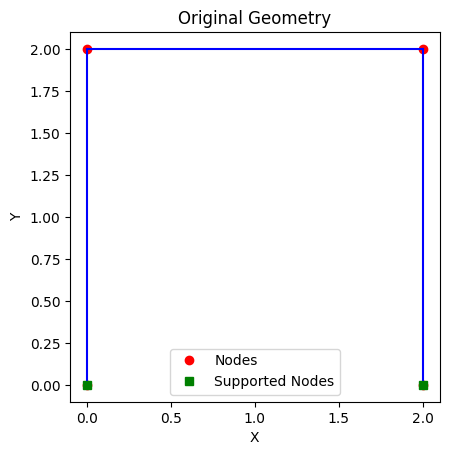

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Geometry data
L = 2.0
nodes = np.array([[0,0],[0,L],[L,L],[L,0]])
elements = np.array([[0,1],[1,2],[2,3]])
supp = np.array([[0,1,1,1], [3,1,1,1]])

# Function to plot the original geometry
def plot_geometry(nodes, elements, supp):
    fig, ax = plt.subplots()
    
    # Plot nodes
    ax.plot(nodes[:, 0], nodes[:, 1], 'ro', label='Nodes')
    
    # Plot elements as lines connecting nodes
    for element in elements:
        element_coords = nodes[element]
        ax.plot(element_coords[:, 0], element_coords[:, 1], 'b-')
    
    # Highlight supported nodes
    for node in supp[:, 0]:
        ax.plot(nodes[node, 0], nodes[node, 1], 'gs', label='Supported Nodes' if node == supp[0, 0] else "")
    
    ax.set_aspect('equal')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Original Geometry')
    plt.legend()
    plt.show()

# Plot the original geometry
plot_geometry(nodes, elements, supp)

In [9]:
num_elements_per_edge = 2

x_coords = np.linspace(0, L, num_elements_per_edge + 1)
y_coords = np.linspace(0, L, num_elements_per_edge + 1)

top_nodes = np.array([[x, L] for x in x_coords if x != 0])
left_nodes = np.array([[0, y] for y in y_coords])
right_nodes = np.array([[L, y] for y in reversed(y_coords) if y != L])

nodes = np.vstack([left_nodes, top_nodes, right_nodes])

elements = np.array([[i, i+1] for i in range(len(nodes)-1)])
flatten_elements = elements.flatten()

supp = np.array([[flatten_elements[0], 1, 1, 1], [flatten_elements[-1], 1, 1, 1]])

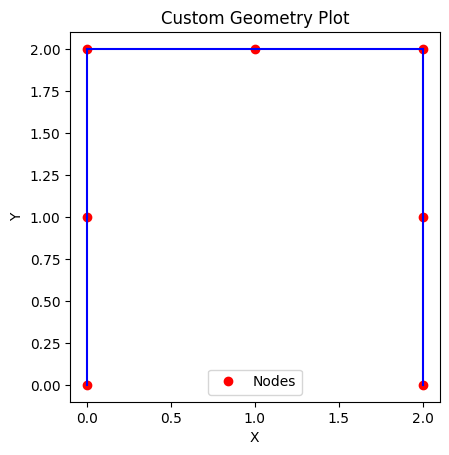

In [10]:
def plot_nodes(nodes):
    fig, ax = plt.subplots()
    
    # Plot nodes
    ax.plot(nodes[:, 0], nodes[:, 1], 'ro', label='Nodes')

    # Plot elements as lines connecting nodes
    for element in elements:
        element_coords = nodes[element]
        ax.plot(element_coords[:, 0], element_coords[:, 1], 'b-')

    ax.set_aspect('equal')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Custom Geometry Plot')
    plt.legend()
    plt.show()

# Plot the nodes
plot_nodes(nodes)

In [11]:
# geometry data
L = 2.0
I = 36e-4
A = 0.12

# material data
E = 20e6

# loads
load = np.array([[2,3],[3,4]])
q = -400
t = 0
f_dist = vem.buildBeamDistributedLoad(load,t,q,nodes)

# stiffness matrix
K = vem.buildGlobaBeamK(nodes, elements, E, A, I, 1)

# apply DBC
K, f = vem.applyDBCBeam(K, f_dist, supp)

# solve
print()
print("######################### Beam ##########################")
uh_vem = np.linalg.solve(K,f)
print(uh_vem)
print("#########################################################")

Coords: [[0. 0.]
 [0. 1.]] - Length: 1.0
Coords: [[0. 1.]
 [0. 2.]] - Length: 1.0
Coords: [[0. 2.]
 [1. 2.]] - Length: 1.0
Coords: [[1. 2.]
 [2. 2.]] - Length: 1.0
Coords: [[2. 2.]
 [2. 1.]] - Length: 1.0
Coords: [[2. 1.]
 [2. 0.]] - Length: 1.0

######################### Beam ##########################
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.44133539e-04
 -1.66666667e-04  1.37341906e-04  2.71665308e-05 -3.33333333e-04
 -6.30867216e-04 -9.29349757e-20 -8.80248423e-04 -9.60632642e-21
 -2.71665308e-05 -3.33333333e-04  6.30867216e-04  1.44133539e-04
 -1.66666667e-04 -1.37341906e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
#########################################################


In [12]:
# Define neural network for the beam problem
class BeamApproximator(nn.Module):
    def __init__(self, input_dim, layers, ndof):
        super(BeamApproximator, self).__init__()
        # First layer from input to the first hidden layer
        self.fin = nn.Linear(input_dim, layers[0])
        
        # Hidden layers
        self.hidden = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        # Final output layer from the last hidden layer to the output (ndof)
        self.fout = nn.Linear(layers[-1], ndof)

    def forward(self, x):
        # Pass through the first layer
        z = torch.relu(self.fin(x))
        
        # Pass through the hidden layers
        for layer in self.hidden:
            z = torch.relu(layer(z))
        
        # Final output layer
        z = self.fout(z)
        
        return z

# Assuming nodes, K, and f are already defined
ndof = 3 * len(nodes)
input_dim = 2*len(nodes)

nodes = nodes.flatten()
nodes = torch.tensor(nodes, dtype=torch.float32, requires_grad=True)

# Initialize the model and optimizer
layers = [128, 128, 256, 256, 512, 512, 512]
model = BeamApproximator(input_dim, layers, ndof)
optimizer = optim.Adam(model.parameters(), lr=0.01)

K = torch.tensor(K, dtype=torch.float32, requires_grad=True)
f = torch.tensor(f, dtype=torch.float32, requires_grad=True)

In [13]:
epochs = 40000
for  epoch in range(epochs):
    optimizer.zero_grad()
    uh = model(nodes)
    loss = compute_loss(K, uh, f)
    loss_bc = compute_boundary_loss(uh, supp)
    loss = loss + loss_bc
    loss.backward()
    optimizer.step()
    print(f'Epoch: {epoch+1}, Loss: {loss.item()}')

Epoch: 1, Loss: 140627673088.0
Epoch: 2, Loss: 781939061555200.0
Epoch: 3, Loss: 42777640960.0
Epoch: 4, Loss: 1938280939520.0
Epoch: 5, Loss: 388256366592.0
Epoch: 6, Loss: 157770203136.0
Epoch: 7, Loss: 1460321910784.0
Epoch: 8, Loss: 15600881664.0
Epoch: 9, Loss: 371669958656.0
Epoch: 10, Loss: 411938652160.0
Epoch: 11, Loss: 353347960832.0
Epoch: 12, Loss: 270519271424.0
Epoch: 13, Loss: 139850219520.0
Epoch: 14, Loss: 47995375616.0
Epoch: 15, Loss: 109202579456.0
Epoch: 16, Loss: 130928107520.0
Epoch: 17, Loss: 42883231744.0
Epoch: 18, Loss: 6426465792.0
Epoch: 19, Loss: 47416520704.0
Epoch: 20, Loss: 71265755136.0
Epoch: 21, Loss: 51077341184.0
Epoch: 22, Loss: 23307300864.0
Epoch: 23, Loss: 13063133184.0
Epoch: 24, Loss: 22009569280.0
Epoch: 25, Loss: 23181891584.0
Epoch: 26, Loss: 12908316672.0
Epoch: 27, Loss: 11729511424.0
Epoch: 28, Loss: 20285368320.0
Epoch: 29, Loss: 17500444672.0
Epoch: 30, Loss: 8368434176.0
Epoch: 31, Loss: 2745090560.0
Epoch: 32, Loss: 3804401152.0
Epo

In [14]:
def compute_energy_error(K, uh_fem, uh_nn):
    """
    Compute the energy error between the FEM and NN solutions.

    Parameters:
    K (torch.Tensor): Stiffness matrix (ndof x ndof)
    uh_fem (torch.Tensor): Displacement field from FEM (ndof x 1)
    uh_nn (torch.Tensor): Displacement field from NN (ndof x 1)

    Returns:
    torch.Tensor: Energy error as a scalar
    """
    # Ensure all tensors are of the same type (float32)
    K = K.float()
    uh_fem = uh_fem.float()
    uh_nn = uh_nn.float()
    
    # Compute strain energy for FEM and NN solutions
    U_fem = 0.5 * torch.matmul(uh_fem.T, torch.matmul(K, uh_fem))
    U_nn = 0.5 * torch.matmul(uh_nn.T, torch.matmul(K, uh_nn))

    # Compute energy error
    energy_error = (U_nn - U_fem) / U_fem
    return energy_error.abs()  # Return the absolute value of the error

import torch

def compute_h1_norm(K, uh_fem, uh_nn):
    """
    Compute the H1 norm between the FEM and NN solutions.
    
    Parameters:
    K (torch.Tensor): Stiffness matrix (ndof x ndof)
    uh_fem (torch.Tensor): Displacement field from FEM (ndof x 1)
    uh_nn (torch.Tensor): Displacement field from NN (ndof x 1)

    Returns:
    torch.Tensor: H1 norm error as a scalar
    """
    # Ensure all tensors are of the same type and have requires_grad=True
    uh_fem = uh_fem.float().requires_grad_(True)
    uh_nn = uh_nn.float().requires_grad_(True)

    # Compute L2 norm of the displacement field
    l2_error = torch.norm(uh_nn - uh_fem) ** 2

    # Compute gradient (strain) of the displacement fields
    grad_uh_fem = torch.autograd.grad(uh_fem.sum(), uh_fem, create_graph=True)[0]
    grad_uh_nn = torch.autograd.grad(uh_nn.sum(), uh_nn, create_graph=True)[0]

    # Compute L2 norm of the gradient (strain)
    grad_error = torch.norm(grad_uh_nn - grad_uh_fem) ** 2

    # Combine L2 norm of the displacement and gradient
    h1_error = torch.sqrt(l2_error + grad_error)

    return h1_error

In [17]:
# Set the model to evaluation mode
model.eval()

# Ensure gradients are not tracked during prediction
with torch.no_grad():
    # Use the trained model to make predictions
    predicted_displacements = model(nodes)

# Print or use the predicted displacements
print("Predicted displacements:", predicted_displacements)

l2_error = compute_l2_error(torch.tensor(uh_vem), predicted_displacements).item()
energy_error = compute_energy_error(K, torch.tensor(uh_vem), predicted_displacements).item()
h1_error = compute_h1_norm(K, torch.tensor(uh_vem), predicted_displacements).item()

print(f"L2 error: {l2_error}")
print(f"Energy error: {energy_error}")
print(f"H1 error: {h1_error}")

Predicted displacements: tensor([-1.4137e-08,  7.0745e-07,  7.5853e-05, -1.8936e-04, -2.1187e-04,
         1.8121e-04,  6.7275e-05, -2.8479e-04, -5.7306e-04, -3.5396e-05,
        -9.6520e-04, -4.9930e-05,  1.4012e-06, -2.2858e-04,  5.7876e-04,
         1.3034e-04, -2.7370e-04, -1.1857e-04, -1.8285e-10,  6.6511e-10,
        -3.6472e-10])
L2 error: 0.1711910803476067
Energy error: 0.509602427482605
H1 error: 0.00023778634204063565
